```Performance Optimization with torch compiler```

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd

## Hyperparameters and Configuration

In [2]:
# Modified hyperparameters
SEQUENCE_LENGTH = 256

EMBEDDING_DIM = SEQUENCE_LENGTH // 2
HIDDEN_DIM = EMBEDDING_DIM*2

BATCH_SIZE = 1024
EPOCHS = 5
LEARNING_RATE = 1e-3
VALIDATION_SPLIT = 0.1

NUM_LAYERS = 6
DROPOUT = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


## Data Preparation

We are using the TinyShakespeare dataset, a small character-level text corpus consisting of a subset of Shakespeare's plays. It's often used for testing sequence models, as it includes a rich set of vocabulary and provides a challenging task for next-character prediction.

In [3]:
## Utility Functions

def load_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def create_char_mappings(text):
    chars = sorted(list(set(text)))
    char_to_idx = {ch: i for i, ch in enumerate(chars)}
    idx_to_char = {i: ch for i, ch in enumerate(chars)}
    return chars, char_to_idx, idx_to_char

## Dataset

In [4]:
class CharDataset(Dataset):
    def __init__(self, text, seq_length, char_to_idx):
        self.text = text
        self.seq_length = seq_length
        self.char_to_idx = char_to_idx

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        x = [self.char_to_idx[ch] for ch in self.text[idx:idx+self.seq_length]]
        y = [self.char_to_idx[ch] for ch in self.text[idx+1:idx+self.seq_length+1]]
        return torch.tensor(x), torch.tensor(y)

In [5]:
def prepare_data(text, seq_length, batch_size, val_split):
    chars, char_to_idx, idx_to_char = create_char_mappings(text)

    # Split data into train and validation
    val_size = int(len(text) * val_split)
    train_text, val_text = text[:-val_size], text[-val_size:]

    train_dataset = CharDataset(train_text, seq_length, char_to_idx)
    val_dataset = CharDataset(val_text, seq_length, char_to_idx)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=12, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=12, pin_memory=True)

    return train_loader, val_loader, chars, char_to_idx, idx_to_char

In [6]:
# !wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=19zosLuU0z4MxIMKbGVYEGlg52QyfbTIy' -O input.txt

In [7]:
# Load the data
text = load_data('../data/input.txt')
train_loader, val_loader, chars, char_to_idx, idx_to_char = prepare_data(text, SEQUENCE_LENGTH, BATCH_SIZE, VALIDATION_SPLIT)
vocab_size = len(chars)

print(f"Total characters: {len(text)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Train dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")

Total characters: 1115394
Vocabulary size: 65
Train dataset size: 1003599
Validation dataset size: 111283


## Data Visualization

In [8]:
# Function to convert index sequence to character sequence
def indices_to_text(indices, idx_to_char):
    return ''.join([idx_to_char[idx.item()] for idx in indices])

# Get a batch of data
dataiter = iter(train_loader)
batch_x, batch_y = next(dataiter)

print(f"Input shape: {batch_x.shape}")
print(f"Target shape: {batch_y.shape}")

# Print a few samples from the batch
num_samples = 3
for i in range(num_samples):
    print(f"Sample {i+1}: ------------------------------" )
    print("Input sequence :", indices_to_text(batch_x[i], idx_to_char).replace('\n',''))
    print("Target sequence:", indices_to_text(batch_y[i], idx_to_char).replace('\n',''))
    print()


Input shape: torch.Size([1024, 256])
Target shape: torch.Size([1024, 256])
Sample 1: ------------------------------
Input sequence :  Murderer:Make peace with God, for you must die, my lord.CLARENCE:Hast thou that holy feeling in thy soul,To counsel me to make my peace with God,And art thou yet to thy own soul so blind,That thou wilt war with God by murdering me?Ah, sirs, consid
Target sequence: Murderer:Make peace with God, for you must die, my lord.CLARENCE:Hast thou that holy feeling in thy soul,To counsel me to make my peace with God,And art thou yet to thy own soul so blind,That thou wilt war with God by murdering me?Ah, sirs, conside

Sample 2: ------------------------------
Input sequence :  to see thee! You are threeThat Rome should dote on: yet, by the faith of men,We have some old crab-trees hereat home that will notBe grafted to your relish. Yet welcome, warriors:We call a nettle but a nettle andThe faults of fools but folly.COMIN
Target sequence: to see thee! You are threeT

## Training Function

In [9]:
def print_vram_usage(device="cuda"):
    allocated = torch.cuda.memory_allocated(device) / (1024**2)  # in MB
    reserved = torch.cuda.memory_reserved(device) / (1024**2)    # in MB
    max_allocated = torch.cuda.max_memory_allocated(device) / (1024**2)  # in MB
    print(f"Allocated: {allocated:.2f} MB, Reserved: {reserved:.2f} MB, Max Allocated: {max_allocated:.2f} MB")

In [10]:
def validate(model, dataloader, criterion, device, epoch, step):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            losses.append((step, epoch, loss.item()))
    return losses

In [11]:
from tqdm import tqdm

def train(model, dataloader, criterion, optimizer, device, epoch, step):
    model.train()
    losses = []
    vram_usage = []
    scaler = torch.amp.GradScaler('cuda')
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}", leave=False)
    for batch, (x, y) in enumerate(pbar):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            output, _ = model(x)
            loss = criterion(output.view(-1, output.size(-1)), y.view(-1))
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        step += 1
        losses.append((step, epoch, loss.item()))
        
        # VRAM 사용량을 progress bar의 postfix로 업데이트
        allocated = torch.cuda.memory_allocated(device) / (1024**2)
        vram_usage.append(allocated)
        pbar.set_postfix(loss=f'{loss.item():.4f}', step=step, vram=f'{allocated:.2f} MB')
    return losses, step, vram_usage

## Generation Function

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    all_train_losses = []
    all_val_losses = []
    all_vram_usages = [] # 에포크별 평균 VRAM 사용량 리스트로 변경 가능 또는 배치별 VRAM 사용량 리스트 유지
    step = 0

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        
        # Training phase
        # epoch_train_losses는 (step, epoch, loss_value) 튜플의 리스트
        epoch_train_losses_list, step, epoch_vram_usage_list = train(model, train_loader, criterion, optimizer, device, epoch, step)
        all_train_losses.extend(epoch_train_losses_list)
        if epoch_vram_usage_list: # CUDA 사용 시에만 vram_usage가 채워짐
             all_vram_usages.extend(epoch_vram_usage_list) # 배치별 VRAM 사용량 모두 저장

        # 현재 에포크의 평균 훈련 로스 계산
        avg_epoch_train_loss = 0
        if epoch_train_losses_list:
            avg_epoch_train_loss = np.mean([loss_tuple[2] for loss_tuple in epoch_train_losses_list])
        
        # Validation phase
        # epoch_val_losses는 (step, epoch, loss_value) 튜플의 리스트
        epoch_val_losses_list = validate(model, val_loader, criterion, device, epoch, step) # validate의 step은 해당 에포크 종료 시점의 step
        all_val_losses.extend(epoch_val_losses_list)
        
        # 현재 에포크의 평균 검증 로스 계산
        avg_epoch_val_loss = 0
        if epoch_val_losses_list:
            avg_epoch_val_loss = np.mean([loss_tuple[2] for loss_tuple in epoch_val_losses_list])
            
        epoch_time = time.time() - epoch_start_time
        
        avg_epoch_vram_str = ""
        if epoch_vram_usage_list: # CUDA 사용 시
            avg_epoch_vram = np.mean(epoch_vram_usage_list)
            avg_epoch_vram_str = f', Avg VRAM: {avg_epoch_vram:.2f}MB'

        print(f'Epoch {epoch}/{epochs}, Avg Train Loss: {avg_epoch_train_loss:.4f}, '
              f'Avg Val Loss: {avg_epoch_val_loss:.4f}, Epoch Time: {epoch_time:.2f}s{avg_epoch_vram_str}')

    train_losses_df = pd.DataFrame(all_train_losses, columns=['step', 'epoch', 'loss_value'])
    val_losses_df = pd.DataFrame(all_val_losses, columns=['step', 'epoch', 'loss_value'])
    
    # all_vram_usages는 모든 배치의 VRAM 사용량을 담고 있으므로, 전체 평균을 계산할 수 있음
    # overall_avg_vram = np.mean(all_vram_usages) if all_vram_usages else 0
    # print(f"Overall Average VRAM Usage: {overall_avg_vram:.2f} MB")
    
    return model, train_losses_df, val_losses_df

In [13]:
def generate_text(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text
    hidden = None

    with torch.no_grad():
        for _ in range(max_length):
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output, hidden = model(x, hidden)
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [14]:
loss_comparison_dict = {}

def add_loss_to_comparison(model_name, train_losses_df, val_losses_df):
    """
    Adds training and validation losses from a model to the comparison dictionary.
    """
    loss_comparison_dict[model_name] = {
        'train': train_losses_df,
        'val': val_losses_df
    }

def print_final_losses(loss_dict):
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        val_df = losses['val']
        final_train = train_df.groupby('epoch')['loss_value'].last().iloc[-1]
        final_val = val_df.groupby('epoch')['loss_value'].last().iloc[-1]
        print(f"{model_name}: Final Train Loss: {final_train:.4f}, Final Val Loss: {final_val:.4f}")

In [15]:
# Function to plot loss curves
def plot_loss(train_losses_df, val_losses_df):
    plt.figure(figsize=(10, 5))

    # Plot training losses
    for epoch in train_losses_df['epoch'].unique():
        epoch_train_losses = train_losses_df[train_losses_df['epoch'] == epoch]
        plt.plot(epoch_train_losses['step'], epoch_train_losses['loss_value'],
                 color='blue', alpha=0.3)

    # scatter training loss at the end of each epoch
    last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
    plt.scatter(last_train_losses['step'], last_train_losses['loss_value'],
                color='blue')

    # Plot and scatter validation loss at the end of each epoch
    last_val_losses = val_losses_df.groupby('epoch').last().reset_index()
    plt.plot(last_val_losses['step'], last_val_losses['loss_value'],
             color='orange', label='Validation Loss')
    plt.scatter(last_val_losses['step'], last_val_losses['loss_value'],
                color='orange')

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to print final loss values
def print_final_losses(train_losses_df, val_losses_df):
    print("Final Training Loss:", train_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])
    print("Final Validation Loss:", val_losses_df.groupby('epoch')['loss_value'].last().iloc[-1])

In [16]:
# Function to plot loss curves for multiple models stored in loss_comparison_dict
def plot_loss_comparisons():
    """
    Plots the training loss curves and average validation loss per epoch for multiple models added to the loss comparison dictionary.
    """
    plt.figure(figsize=(10, 5))
    
    # Get the last model in the dictionary (for special final-point highlighting)
    last_model_name = list(loss_comparison_dict.keys())[-1]

    # Loop through each model in the loss dictionary
    for model_name, losses in loss_comparison_dict.items():
        train_losses_df = losses['train']
        val_losses_df = losses['val']

        # Plot training losses for each model
        plt.plot(train_losses_df['step'], train_losses_df['loss_value'],
                 label=f'{model_name} train', linestyle='-', alpha=0.7)

        # Scatter training loss at the end of each epoch
        last_train_losses = train_losses_df.groupby('epoch').last().reset_index()
        plt.scatter(last_train_losses['step'], last_train_losses['loss_value'], marker='o', s=50)

        # Compute average validation loss per epoch (using the last step of each epoch for x-axis)
        avg_val_losses = val_losses_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        # Scatter the average validation loss for each epoch
        plt.scatter(avg_val_losses['step'], avg_val_losses['loss_value'], marker='s', s=50,
                    label=f'{model_name} val avg')

        # For the last model, highlight the final training loss with a star
        if model_name == last_model_name:
            final_step = train_losses_df['step'].iloc[-1]
            final_loss = train_losses_df['loss_value'].iloc[-1]
            plt.scatter(final_step, final_loss, marker='*', s=100, color='red', zorder=5)

    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()  # Legend shows both training and validation average labels
    plt.grid(True)
    plt.show()


In [17]:
def plot_separate_train_val(loss_dict):
    """
    모델별 Training Loss와 Validation Loss를 각각 별도의 그래프로 그립니다.
    단, Validation Loss는 에포크별 평균으로 계산합니다.
    """
    # 1. Training Loss Plot (원본 그대로)
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
    for model_name, losses in loss_dict.items():
        train_df = losses['train']
        steps_train = train_df['step'].values
        loss_train = train_df['loss_value'].values
        plt.plot(steps_train, loss_train, label=f'{model_name} Train')
    plt.title('Training Loss Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. Validation Loss Plot (에포크별 평균 처리)
    plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
    for model_name, losses in loss_dict.items():
        val_df = losses['val']
        # 에포크별 평균 loss와 마지막 step을 계산
        val_avg = val_df.groupby('epoch').agg({'loss_value': 'mean', 'step': 'last'}).reset_index()
        plt.plot(val_avg['step'], val_avg['loss_value'], label=f'{model_name} Val')
    plt.title('Validation Loss (Epoch Avg) Comparison')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [18]:
# Text generation using validation data
val_sample, _ = next(iter(val_loader))
start_text = ''.join([idx_to_char[idx.item()] for idx in val_sample[0][:SEQUENCE_LENGTH]])

In [19]:
# Decoder Input/Output Example
sample_input, _ = next(iter(val_loader))
sample_input = sample_input[0].unsqueeze(0).to(device)  # Add batch dimension

In [20]:
def generate_text_attention(model, char_to_idx, idx_to_char, start_text, device, max_length=500):
    model.eval()
    current_text = start_text

    with torch.no_grad():
        for _ in range(max_length):
            # Convert the last sequence of characters to indices and feed it to the model
            x = torch.tensor([[char_to_idx[ch] for ch in current_text[-SEQUENCE_LENGTH:]]]).to(device)
            output = model(x)[0]  # No hidden state needed for attention-based models
            probs = torch.softmax(output[0, -1], dim=0)
            next_char_idx = torch.multinomial(probs, 1).item()
            next_char = idx_to_char[next_char_idx]
            current_text += next_char

    return current_text

In [21]:
def train_and_test(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

## Restructure minGRU
- 기존 모델 구조는 torch.compile과 호환되기 어려운 구조이므로, 이전에 구현했던 구조 중 하나인 llama like structure를 이용

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math  # math.log 및 상수 사용을 위함
from tqdm import tqdm  # tqdm 임포트 추가


def log_g(x: torch.Tensor) -> torch.Tensor:
    """
    은닉 상태 후보를 로그 공간으로 변환하는 함수.
    x >= 0 이면 log(x + 0.5)
    x < 0 이면 log(sigmoid(x))
    """
    return torch.where(x >= 0, (F.relu(x) + 0.5).log(), -F.softplus(-x))


def parallel_scan_log(log_coeffs: torch.Tensor, log_values: torch.Tensor) -> torch.Tensor:
    """
    로그 공간에서 병렬 스캔 연산을 수행합니다. (클램핑 제거됨)
    Args:
        log_coeffs (torch.Tensor): [B, L, H_internal] 형태의 텐서로, log(alpha_t)를 나타냅니다.
        log_values (torch.Tensor): [B, L+1, H_internal] 형태의 텐서로, [log_h_initial, log(beta_1), ..., log(beta_L)]를 나타냅니다.
    Returns:
        torch.Tensor: [B, L, H_internal] 형태의 텐서로, 지수 함수가 적용된 은닉 상태 (h_1 부터 h_L까지)를 나타냅니다.
    """
    log_proda_coeffs_prefix = F.pad(torch.cumsum(log_coeffs, dim=1), (0, 0, 1, 0), value=0.0)
    terms_for_logcumsumexp = log_values - log_proda_coeffs_prefix
    log_sum_exp_terms = torch.logcumsumexp(terms_for_logcumsumexp, dim=1)
    log_hidden_states = log_proda_coeffs_prefix + log_sum_exp_terms
    output_hidden_states = torch.exp(log_hidden_states[:, 1:, :])
    return output_hidden_states


class ParallelLogMinGRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, expansion_factor: float = 1.0, epsilon: float = 1e-7):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.expansion_factor = expansion_factor  # GRU 셀 내부의 확장 계수
        self.internal_expanded_dim = int(hidden_size * self.expansion_factor)
        self.epsilon = epsilon

        self.to_hidden_and_gate = nn.Linear(input_size, self.internal_expanded_dim * 2)
        if self.expansion_factor != 1.0:
            self.to_out = nn.Linear(self.internal_expanded_dim, hidden_size)
        else:
            self.to_out = nn.Identity()
        self._init_weights()

    def _init_weights(self):
        for name, param in self.named_parameters():
            if 'to_hidden_and_gate' in name or 'to_out' in name:
                if 'weight' in name:
                    nn.init.xavier_uniform_(param)
                elif 'bias' in name and param is not None:
                    nn.init.zeros_(param)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, L, input_size]
        B, L, _ = x.size()
        hidden_and_gate = self.to_hidden_and_gate(x)  # [B, L, internal_expanded_dim * 2]
        h_candidate_input_expanded, logits_z_expanded = hidden_and_gate.chunk(2, dim=-1)

        log_A = F.logsigmoid(-logits_z_expanded)
        log_Z_expanded = F.logsigmoid(logits_z_expanded)
        log_h_candidate_contrib_expanded = log_g(h_candidate_input_expanded)
        log_B = log_Z_expanded + log_h_candidate_contrib_expanded

        log_h0_val = torch.full(
            (B, 1, self.internal_expanded_dim),
            math.log(self.epsilon),
            device=x.device,
            dtype=x.dtype
        )
        log_vals = torch.cat([log_h0_val, log_B], dim=1)  # [B, L+1, internal_expanded_dim]
        h_expanded_scan_out = parallel_scan_log(log_A, log_vals)  # [B, L, internal_expanded_dim]

        output = self.to_out(h_expanded_scan_out)  # [B, L, hidden_size]
        return output


class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-8):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        variance = x.pow(2).mean(dim=-1, keepdim=True)
        return x * torch.rsqrt(variance + self.eps) * self.gamma


class CausalDepthWiseConv1d(nn.Module):
    def __init__(self, dim: int, kernel_size: int):
        super().__init__()
        self.kernel_size = kernel_size
        self.net = nn.Sequential(
            nn.Conv1d(dim, dim, kernel_size=kernel_size, groups=dim),
            nn.Conv1d(dim, dim, kernel_size=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_orig_shape = x.shape
        if x.dim() == 2:
            x = x.unsqueeze(0)
        x_transposed = x.transpose(1, 2)
        x_padded = F.pad(x_transposed, (self.kernel_size - 1, 0), value=0.0)
        x_conv_out = self.net(x_padded)
        x_restored = x_conv_out.transpose(1, 2)
        if len(x_orig_shape) == 2 and x_restored.shape[0] == 1:
            x_restored = x_restored.squeeze(0)
        return x_restored


class SwiGLUFFN(nn.Module):
    def __init__(self, dim: int, expansion_factor: float = 4.0, dropout: float = 0.1):
        super().__init__()
        ffn_hidden_dim = int(dim * expansion_factor)

        self.w1_w3 = nn.Linear(dim, ffn_hidden_dim * 2, bias=False)
        self.w2 = nn.Linear(ffn_hidden_dim, dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_proj = self.w1_w3(x)
        x1, x3_gate = x_proj.chunk(2, dim=-1)
        hidden_states = F.silu(x1) * x3_gate
        hidden_states = self.dropout(hidden_states)
        return self.w2(hidden_states)


class minGRULM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        num_layers: int = 2,
        dropout: float = 0.1,
        expansion_factor_gru: float = 1.0,
        epsilon_gru: float = 1e-7,
        rms_norm_eps: float = 1e-8,
        ffn_expansion_factor: float = 2.0,
        conv_kernel_size: int = 3            # ← 여기에 컨볼루션 커널 크기 파라미터 추가
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.input_projection = nn.Linear(embedding_dim, hidden_dim)
        # ─── 입력 프로젝션 이후에 CausalDepthWiseConv1d 모듈을 추가 ───
        self.conv = CausalDepthWiseConv1d(hidden_dim, conv_kernel_size)
        # ─────────────────────────────────────────────────────────

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            ffn_layer = SwiGLUFFN(
                dim=hidden_dim,
                expansion_factor=ffn_expansion_factor,
                dropout=dropout
            )

            self.layers.append(nn.ModuleList([
                RMSNorm(hidden_dim, eps=rms_norm_eps),
                ParallelLogMinGRU(
                    input_size=hidden_dim,
                    hidden_size=hidden_dim,
                    expansion_factor=expansion_factor_gru,
                    epsilon=epsilon_gru
                ),
                RMSNorm(hidden_dim, eps=rms_norm_eps),
                ffn_layer,
                nn.Dropout(dropout) if dropout > 0. else nn.Identity()
            ]))

        self.final_norm = RMSNorm(hidden_dim, eps=rms_norm_eps)
        self.to_vocab = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x: torch.Tensor):
        h = self.embedding(x)                    # [B, L, embedding_dim]
        h = self.input_projection(h)             # [B, L, hidden_dim]

        # ─── input_projection 직후에 causal conv1d 적용 ───
        h = self.conv(h)                         # [B, L, hidden_dim]
        # ───────────────────────────────────────────────────

        for block_idx, block_modules in enumerate(self.layers):
            norm_gru_input, gru_cell, norm_ff_input, ffn_module, dropout_block_output = block_modules

            # ┌── GRU 블록 + 잔차
            h_gru_residual_source = h
            h_normed_for_gru = norm_gru_input(h)
            h_gru_out = gru_cell(h_normed_for_gru)
            h = h_gru_residual_source + h_gru_out
            # └───────────────────────

            # ┌── FFN 블록 + 잔차
            h_ff_residual_source = h
            h_normed_for_ff = norm_ff_input(h)
            h_ff_out = ffn_module(h_normed_for_ff)
            h = h_ff_residual_source + h_ff_out
            # └───────────────────────

            h = dropout_block_output(h)

        h = self.final_norm(h)
        logits = self.to_vocab(h)
        return logits, None

In [23]:
### Model Initialization
mingru2 = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.2), NUM_LAYERS).to(device)

In [24]:
from torchinfo import summary

summary(mingru2, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 128]          8,320
├─Linear: 1-2                            [1024, 256, 307]          39,603
├─CausalDepthWiseConv1d: 1-3             [1024, 256, 307]          --
│    └─Sequential: 2-1                   [1024, 307, 256]          --
│    │    └─Conv1d: 3-1                  [1024, 307, 256]          1,228
│    │    └─Conv1d: 3-2                  [1024, 307, 256]          94,556
├─ModuleList: 1-4                        --                        --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-3                 [1024, 256, 307]          307
│    │    └─ParallelLogMinGRU: 3-4       [1024, 256, 307]          189,112
│    │    └─RMSNorm: 3-5                 [1024, 256, 307]          307
│    │    └─SwiGLUFFN: 3-6               [1024, 256, 307]       

Epoch 1/5, Avg Train Loss: 1.3364, Avg Val Loss: 1.6517, Epoch Time: 557.18s, Avg VRAM: 126.28MB


Epoch 2/5, Avg Train Loss: 0.8595, Avg Val Loss: 1.9857, Epoch Time: 559.90s, Avg VRAM: 126.44MB


Epoch 3/5, Avg Train Loss: 0.6875, Avg Val Loss: 2.1980, Epoch Time: 560.20s, Avg VRAM: 126.44MB


Epoch 4/5, Avg Train Loss: 0.5868, Avg Val Loss: 2.3406, Epoch Time: 558.99s, Avg VRAM: 126.44MB


Epoch 5/5, Avg Train Loss: 0.5233, Avg Val Loss: 2.4558, Epoch Time: 560.48s, Avg VRAM: 126.44MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathar]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina,
Because authority, thou owest to have his hands begun.

Second Keeper:
Ay, but they were an ired; and that's sure of a costle.

Page:
My lord, I have been still a happy day still his limbs,
And nothing can give him death: do not say 'banished'?
O friar, the dearest mother of the moon cannibally;
And the be that, th

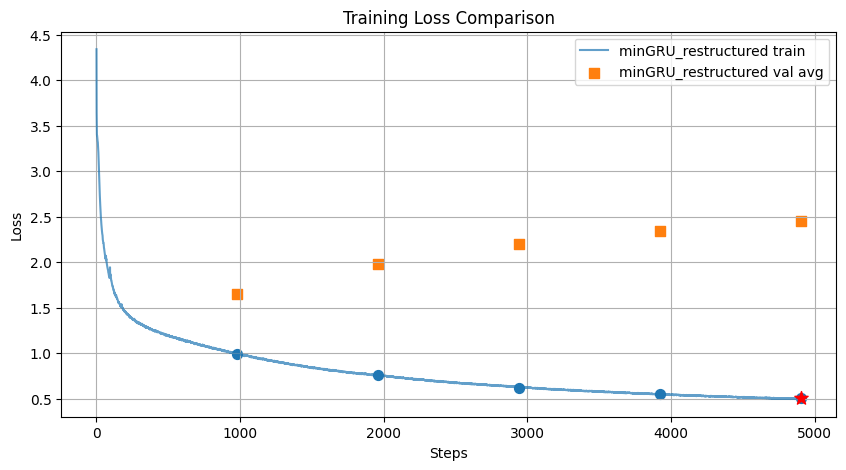

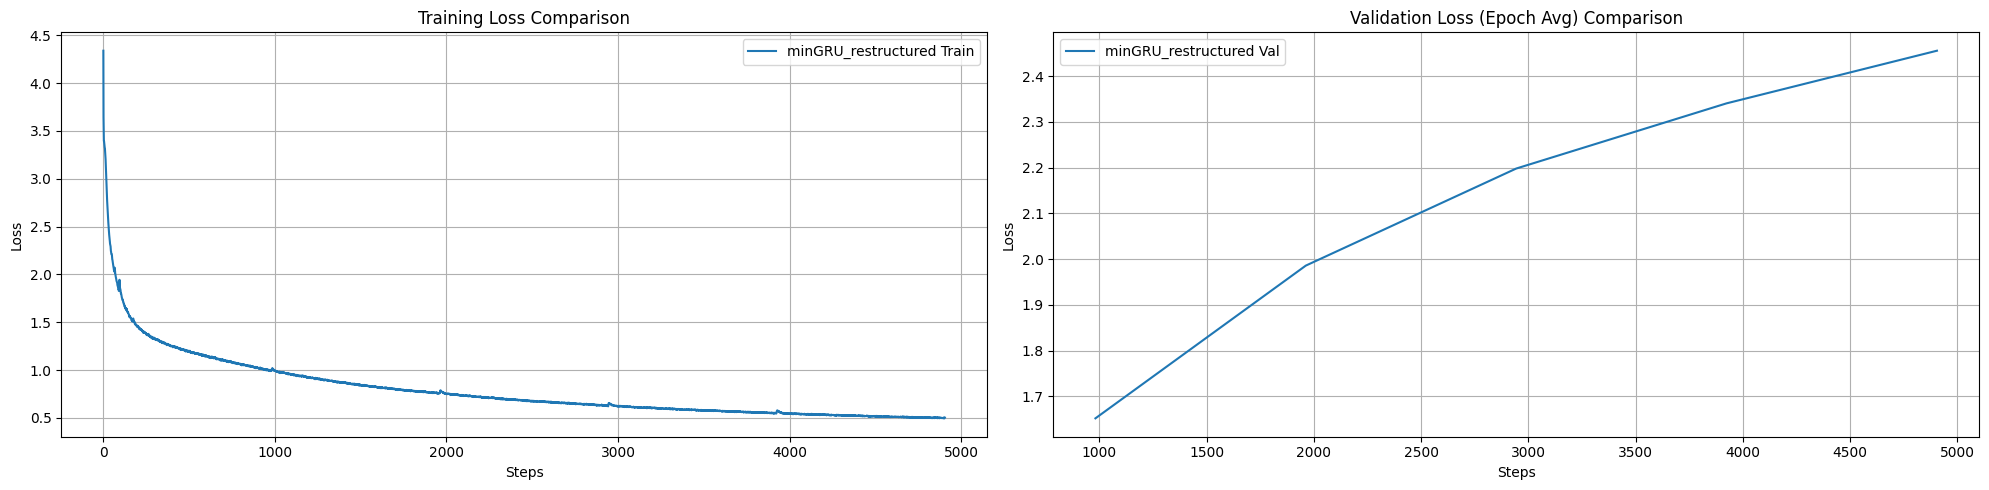

In [25]:
train_and_test("minGRU_restructured", mingru2, start_text)

## Compiled minGRU

In [26]:
torch.set_float32_matmul_precision('high')

In [27]:
def train_and_test2(model_desc, model, start_text):
    # Initialize the model
    model = model.to(device)
    # 다양한 컴파일 모드:
        # "default": 좋은 성능과 컴파일 시간의 균형
        # "reduce-overhead": 컴파일 오버헤드 감소 (작은 모델에 유리)
        # "max-autotune": 가장 긴 컴파일 시간, 가장 높은 성능 목표
    model = torch.compile(model, mode="reduce-overhead")
    # Use the same optimizer and criterion
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, fused=True)
    
    # Train the model
    trained_model, train_losses_df, val_losses_df = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, EPOCHS
    )

    # Generate text
    generated_text = generate_text_attention(trained_model, char_to_idx, idx_to_char, start_text, device)
    print(f"Generated text [{start_text}]:")
    print("-"*50)
    print(generated_text)
    
    add_loss_to_comparison(model_desc, train_losses_df, val_losses_df)

    # Plot loss comparisons including this model
    plot_loss_comparisons()
    
    plot_separate_train_val(loss_comparison_dict)

In [28]:
### Model Initialization
mingru3 = minGRULM(vocab_size, EMBEDDING_DIM, int(HIDDEN_DIM*1.2), NUM_LAYERS).to(device)

In [29]:
from torchinfo import summary

summary(mingru3, input_size=(BATCH_SIZE, SEQUENCE_LENGTH), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
minGRULM                                 [1024, 256, 65]           --
├─Embedding: 1-1                         [1024, 256, 128]          8,320
├─Linear: 1-2                            [1024, 256, 307]          39,603
├─CausalDepthWiseConv1d: 1-3             [1024, 256, 307]          --
│    └─Sequential: 2-1                   [1024, 307, 256]          --
│    │    └─Conv1d: 3-1                  [1024, 307, 256]          1,228
│    │    └─Conv1d: 3-2                  [1024, 307, 256]          94,556
├─ModuleList: 1-4                        --                        --
│    └─ModuleList: 2-2                   --                        --
│    │    └─RMSNorm: 3-3                 [1024, 256, 307]          307
│    │    └─ParallelLogMinGRU: 3-4       [1024, 256, 307]          189,112
│    │    └─RMSNorm: 3-5                 [1024, 256, 307]          307
│    │    └─SwiGLUFFN: 3-6               [1024, 256, 307]       

Epoch 1/5, Avg Train Loss: 1.3322, Avg Val Loss: 1.6711, Epoch Time: 335.54s, Avg VRAM: 95.78MB


Epoch 2/5, Avg Train Loss: 0.8508, Avg Val Loss: 2.0037, Epoch Time: 236.65s, Avg VRAM: 95.77MB


Epoch 3/5, Avg Train Loss: 0.6729, Avg Val Loss: 2.2518, Epoch Time: 234.03s, Avg VRAM: 95.64MB


Epoch 4/5, Avg Train Loss: 0.5759, Avg Val Loss: 2.3551, Epoch Time: 233.91s, Avg VRAM: 95.64MB


Epoch 5/5, Avg Train Loss: 0.5144, Avg Val Loss: 2.4805, Epoch Time: 235.25s, Avg VRAM: 95.64MB
Generated text [

GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Kathar]:
--------------------------------------------------


GREMIO:
Good morrow, neighbour Baptista.

BAPTISTA:
Good morrow, neighbour Gremio.
God save you, gentlemen!

PETRUCHIO:
And you, good sir! Pray, have you not a daughter
Call'd Katharina, fair and virtuous?

BAPTISTA:
I have a daughter, sir, called Katharina that Barnardine
but the pant is very grief, yet your life is lesser to the wall.

DUKE VINCENTIO:
You were not bid me say 'thwack it seemss from me and the
way; for I would have spoke of: being the hate not of it
for your own turn, I see the common bestow of the king.
But what said Warwick to the sea-sudden crown?

K

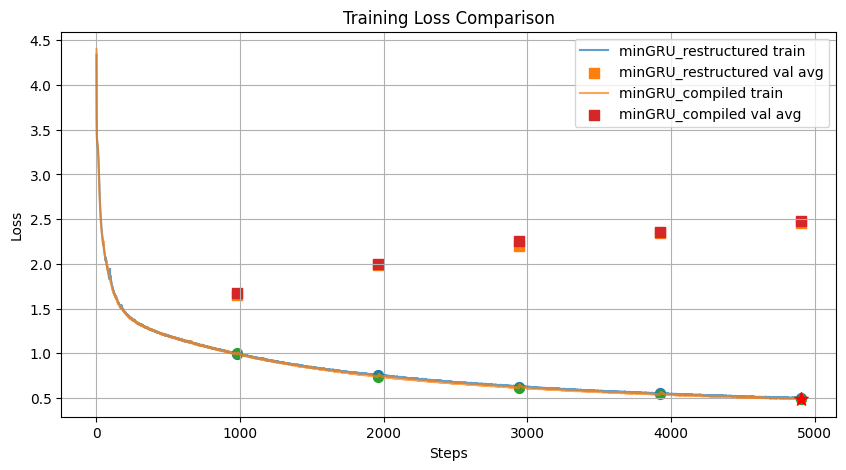

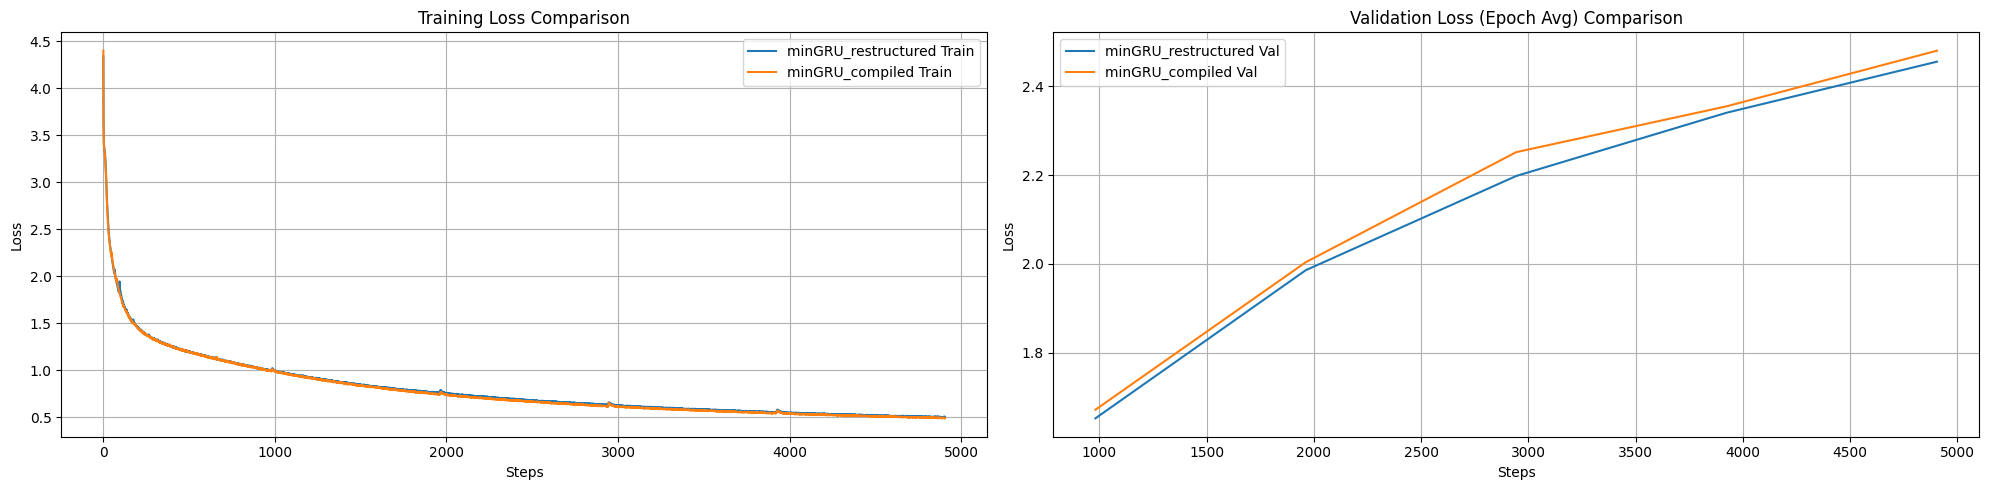

In [30]:
train_and_test2("minGRU_compiled", mingru3, start_text)